# Offshore CIOPS Quantitative Runs

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import datetime as dt
import math
from matplotlib.gridspec import GridSpec
import pandas as pd

### general variables:

In [2]:
tide=24
Ssdep = -100
Wsdep = -150
offcut = 595

In [3]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [4]:
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [5]:
#in the format [section, igridW, igridE, fjgrid, maxdepth] for horizontal CS
# OR for vertical [section, jgridS, jgridN, figrid, maxdepth]
init = [1,259, 274, 640,250] #v
North = [2, 531, 585, 320, 500] #h
Sshelf = [5, 634, 644, 200, 180] #h
Sslope = [4, 595, 633, 200, 500] #h
Offshore = [3, 199, 319, 555, 500] # v

In [6]:
salfileS17 = xr.open_dataset('/ocean/rbeutel/CIOPSBC12_hourly/seasonal_salinity/S_avg_20170507_20170930.nc')
salfileW16 = xr.open_dataset('/ocean/rbeutel/CIOPSBC12_hourly/seasonal_salinity/S_avg_20161002_20170527.nc')
salfileW17 = xr.open_dataset('/ocean/rbeutel/CIOPSBC12_hourly/seasonal_salinity/S_avg_20171001_20180331.nc')

In [7]:
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
start = h+sum(mon_len[:2])*24 #so that we are only using the part of summer that's actually summer!

### general functions:

In [8]:
# sig figs
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [9]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='lightgray')
    return(pc)

# Total Flow

In [10]:
def FluxEW(mydata, start, salfile, section, lonW, lonE, fjgrid, maxdepth, distlabel, ax, title):
    igrid = fjgrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1] - (start-3601)
    
    f_lons = mymesh.glamf[0, igrid]
    u_lons = mymesh.glamv[0, igrid]
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum())).values
    f_dist = f_lons/m2lon
    w_depths = mymesh.gdepw_1d
    xs, ys = np.meshgrid(np.array(f_lons[lonW-1:lonE+1]), np.array(w_depths[0]))
    
    gridding = 1
    tick = 0.01
    units = '$m^3 \, s^{-1} m^{-2}$'
    
    cmap = cm.speed
    cmap.set_under('white')
    
    t_min = 0.00000000001
    
    if type(section) == list:
        offcut = 595
        lons = mydata.final_lon[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1]) & (mydata.final_x > offcut) &(mydata.init_t >= start)]
        dist = f_lons/m2lon
        depths = depthf(mydata.final_z[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1]) & (mydata.final_x > offcut) &(mydata.init_t >= start)]-1.)[0]
        transports = mydata.final_transp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1]) & (mydata.final_x > offcut) &(mydata.init_t >= start)]/time
        t_max = (tick/np.sum(transports)).values/m2lon
    
    else:
        lons = mydata.final_lon[(mydata.final_section==section)&(mydata.init_t >= start)]
        dist = f_lons/m2lon
        depths = depthf(mydata.final_z[(mydata.final_section==section)&(mydata.init_t >= start)]-1.)[0]
        transports = mydata.final_transp[(mydata.final_section==section)&(mydata.init_t >= start)]/time
        t_max = (tick/np.sum(transports)).values/m2lon
        
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(f_lons[lonW-1:lonE:gridding]), w_depths[0]],weights= transports, cmap=cmap, vmin = t_min, vmax=t_max, density= True)
    
    salinity = 0.5*(np.ma.array(salfile.so[:, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.so[:, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=6)

    if distlabel == True:
        distance = abs(round_to_3((f_dist[lonW-1]-f_dist[lonE+1]).values/1000))
        ax.set_xlabel(str(distance)[:-2]+" km")#, fontsize=14)
#     else:
#         ax.set_xlabel("Longitude", fontsize=14)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([u_lons[lonW+2], u_lons[lonE-2]])
    ax.set_xticklabels(np.round([u_lons[lonW+2], u_lons[lonE-2]],2))
    ax.set_xlim((u_lons[lonW], u_lons[lonE]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title))#, fontsize=16)
#     ax.set_ylabel('Depth [m]', fontsize=14)
    ax.set_yticklabels([])
    mydata.close()

In [11]:
def FluxOffshore(data, start, latS, latN, lonE, lonW, fjgrid, figrid, maxdepth, distlabel, ax, title):
    igrid = figrid-1
    jgrid = fjgrid-1
    time = data.init_t[-1] - (start-3601)
    xloc = data.final_lon[np.logical_or((data.final_section==Offshore[0]),(data.final_section==Sslope[0])) & (data.final_x <= offcut) &(data.init_t >= start)]
    depths = depthf(data.final_z[np.logical_or((data.final_section==Offshore[0]),(data.final_section==Sslope[0])) & (data.final_x <= offcut) &(data.init_t >= start)])[0]
    yloc = data.final_lat[np.logical_or((data.final_section==Offshore[0]),(data.final_section==Sslope[0])) & (data.final_x <= offcut) &(data.init_t >= start)]
    transports = data.final_transp[np.logical_or((data.final_section==Offshore[0]),(data.final_section==Sslope[0])) & (data.final_x <= offcut) &(data.init_t >= start)]/time
    salt = data.final_salt[np.logical_or((data.final_section==Offshore[0]),(data.final_section==Sslope[0])) & (data.final_x <= offcut) &(data.init_t >= start)]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    
    u_lons = mymesh.glamv[0, igrid]
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum()))
    
    w_depths = mymesh.gdepw_1d
    
    dist = xloc/m2lon + yloc/m2lat
    distN = (dist - np.min(dist))
    
    numbins = (latN-latS) + (lonE-lonW)
    bins = [np.linspace(0,np.max(distN)+1,numbins), w_depths[0]]
    
    cmap = cm.speed
    cmap.set_under('white')
    
    t_min = 0.00000000001
    tick = 0.01
    # tick = 0.00000001
    t_max = (tick/np.sum(transports)).values/m2lat
    H1, xedges, yedges, im = ax.hist2d(distN, depths, bins=bins,weights= transports, cmap=cmap, vmin = t_min, vmax=t_max, density= True)
    
    units = '$m^3 \, s^{-1} m^{-2}$'
    
    # now the salt contour stuff
    bins2=[np.linspace(0,np.max(distN)+20000,12),w_depths[0]]
    H = binned_statistic_2d(distN, depths, salt, statistic=np.mean, bins=bins2)
    _, xedges2, yedges2 = np.histogram2d(distN, depths, bins = bins2)
    h = H.statistic.T

    X, Y = np.meshgrid(xedges, yedges)
    X2, Y2 = np.meshgrid(xedges2, yedges2)

    CS = ax.contour(X2[:-1,:-1],Y2[:-1,:-1], h, [32,33,34], colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=6)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    # add line P points 4 and 5
#     distP4 = (48.650000/m2lat + -126.666667/m2lon) - np.min(dist)
#     distP5 = (48.691667/m2lat + -127.1666677/m2lon) - np.min(dist)
#     ax.scatter([distP4,distP5],[10,10],color='k',marker='*',s = 150,label='Nearby Line P Stations')
#     ax.legend(loc='lower right')
    
    if distlabel == True:
        distance = round_to_3(np.max(distN/1000).values)
        ax.set_xlabel(str(distance)[:-2]+" km")#, fontsize=14)
    

    ax.invert_yaxis()
    ax.set_xticks([np.min(distN),np.max(distN)])
    
    ticklabels = [str(np.round(t_lat[latS],2).values) +' N,\n'+ str(np.round(u_lons[lonE],2).values)+' E', str(np.round(t_lat[latN],2).values) +' N,\n'+ str(np.round(u_lons[lonW],2).values)+' E']
    ax.set_xticklabels(ticklabels)
    
    
    ax.set_xlim((0, np.max(distN)))
    ax.set_ylim((maxdepth, 0))
    full_title = str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title))#, fontsize=16)
    ax.set_ylabel('Depth [m]')#, fontsize=14)
    ax.set_yticklabels([])
    data.close()

    # return xedges

In [12]:
def FluxSpecificNS(latS, latN, fjgrid, maxdepth, ax, lats, trans, depth, high, salfile, distlabel):
    jgrid = fjgrid-1
    fmask = mymesh.fmask[0, :, : ,jgrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[jgrid]
    time = mydata.init_t[-1]
    
    t_lats = mymesh.gphit[0, :, jgrid]
    m2lat = ((t_lats[latN]-t_lats[latS])/(mymesh.e2t[0, latS:latN, jgrid].sum()))
    t_dist = t_lats/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    t_max = (high/np.sum(trans)).values

    dist = lats/m2lat
        
    H1, _, _ = np.histogram2d(dist, depth, bins=bins,weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    
    xs, ys = np.meshgrid(np.array(t_dist[latS-1:latN+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.so[:, latS-1:latN+1, jgrid],
    mask=1-tmask[:, latS-1:latN+1, jgrid]) +
    np.ma.array(salfile.so[:, latS-1:latN+1, jgrid+1],
    mask=1-tmask[:, latS-1:latN+1, jgrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,36, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=6)
    
    if distlabel == True:
        distance = abs(round_to_3((t_dist[latS-1]-t_dist[latN+1]).values/1000))
        ax.set_xlabel(str(distance)[:-2]+" km")
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[latS+1], t_dist[latN-2]])
    if latS == 259:
        ax.set_xticklabels(['US','CA'])#, fontsize=16)
    else:
        ax.set_xticklabels(np.round([t_lats[latS+1], t_lats[latN-2]],2))
    ax.set_xlim((t_dist[latS], t_dist[latN-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')#, fontsize=14)

    full_title = str(round_to_2(np.sum(trans).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title))#, fontsize=16)

    mydata.close()

In [13]:
prtlen = int(26/2)
offlen = int(146/2)
southlen = int(82/2)
norlen = int(86/2)

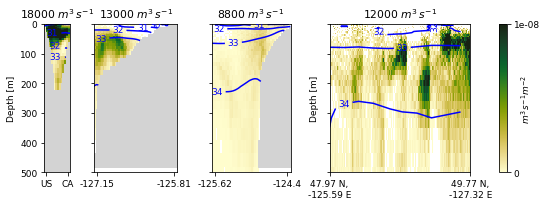

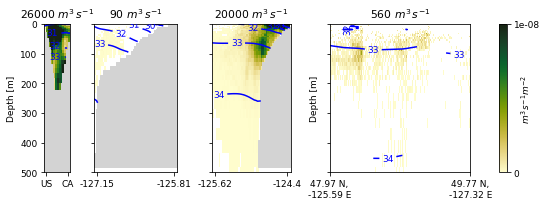

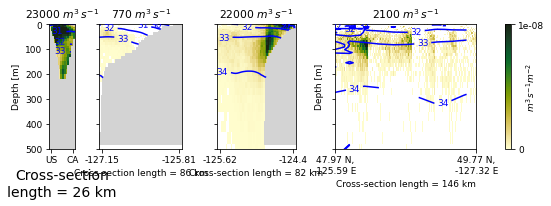

In [14]:
# one presentable figure with all the offshore stuff for the three seasons togetha
plt.rcParams['font.size'] = 9

#summer 2017
distlabel = False
mm = 1/2.54/10
fig = plt.figure(constrained_layout=True, figsize=[190*mm,70*mm])
gs = GridSpec(1, sum([prtlen,offlen,southlen,norlen]), figure=fig)
ax0 = fig.add_subplot(gs[0, :prtlen])
ax1 = fig.add_subplot(gs[0, prtlen:(prtlen+norlen)])
ax2 = fig.add_subplot(gs[0, (prtlen+norlen):(prtlen+norlen+southlen)])
ax3 = fig.add_subplot(gs[0, (prtlen+norlen+southlen):])

mydata = Sdata
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax0.set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], 500, ax0, lats, trans, depth, 0.01, salfileW16, distlabel)

FluxEW(Sdata, start, salfileS17, North[0], North[1], North[2], North[3], North[4], distlabel, ax1, '')
FluxEW(Sdata, start, salfileS17, [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax2, '')
FluxOffshore(Sdata, start, 199, 319, 595, 531, 555, 259, 500, distlabel, ax3, '')
plt.savefig("./figures/OffFluxS17.pdf")

fig = plt.figure(constrained_layout=True, figsize=[190*mm,70*mm])
gs = GridSpec(1, sum([prtlen,offlen,southlen,norlen]), figure=fig)
ax0 = fig.add_subplot(gs[0, :prtlen])
ax1 = fig.add_subplot(gs[0, prtlen:(prtlen+norlen)])
ax2 = fig.add_subplot(gs[0, (prtlen+norlen):(prtlen+norlen+southlen)])
ax3 = fig.add_subplot(gs[0, (prtlen+norlen+southlen):])

mydata = Wdata16
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax0.set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], 500, ax0, lats, trans, depth, 0.01, salfileW16, distlabel)

FluxEW(Wdata16, h, salfileW16, North[0], North[1], North[2], North[3], North[4], distlabel, ax1, '')
FluxEW(Wdata16, h, salfileW16, [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax2, '')
FluxOffshore(Wdata16, h, 199, 319, 595, 531, 555, 259, 500, distlabel, ax3, '')
plt.savefig("./figures/OffFluxW16.pdf")

distlabel = True
fig = plt.figure(constrained_layout=True, figsize=[190*mm,70*mm])
gs = GridSpec(1, sum([prtlen,offlen,southlen,norlen]), figure=fig)
ax0 = fig.add_subplot(gs[0, :prtlen])
ax1 = fig.add_subplot(gs[0, prtlen:(prtlen+norlen)])
ax2 = fig.add_subplot(gs[0, (prtlen+norlen):(prtlen+norlen+southlen)])
ax3 = fig.add_subplot(gs[0, (prtlen+norlen+southlen):])

mydata = Wdata17
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax0.set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], 500, ax0, lats, trans, depth, 0.01, salfileW16, distlabel)

FluxEW(Wdata17, h, salfileW17, North[0], North[1], North[2], North[3], North[4], distlabel, ax1, '')
FluxEW(Wdata17, h, salfileW17, [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax2, '')
FluxOffshore(Wdata17, h, 199, 319, 595, 531, 555, 259, 500, distlabel, ax3, '')
# plt.savefig("./figures/OffFluxW17.pdf")

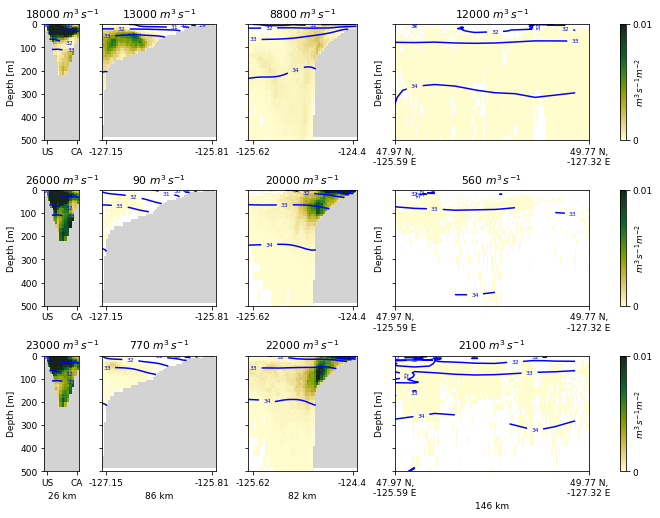

In [14]:
plt.rcParams['font.size'] = 9
mm = 1/2.54/10
fig = plt.figure(constrained_layout=True, figsize=[230*mm,180*mm])
gs = GridSpec(3, sum([prtlen,offlen,southlen,norlen]), figure=fig)
ax00 = fig.add_subplot(gs[0, :prtlen])
ax10 = fig.add_subplot(gs[0, prtlen:(prtlen+norlen)])
ax20 = fig.add_subplot(gs[0, (prtlen+norlen):(prtlen+norlen+southlen)])
ax30 = fig.add_subplot(gs[0, (prtlen+norlen+southlen):])
ax01 = fig.add_subplot(gs[1, :prtlen])
ax11 = fig.add_subplot(gs[1, prtlen:(prtlen+norlen)])
ax21 = fig.add_subplot(gs[1, (prtlen+norlen):(prtlen+norlen+southlen)])
ax31 = fig.add_subplot(gs[1, (prtlen+norlen+southlen):])
ax02 = fig.add_subplot(gs[2, :prtlen])
ax12 = fig.add_subplot(gs[2, prtlen:(prtlen+norlen)])
ax22 = fig.add_subplot(gs[2, (prtlen+norlen):(prtlen+norlen+southlen)])
ax32 = fig.add_subplot(gs[2, (prtlen+norlen+southlen):])

#summer 2017
distlabel = False

mydata = Sdata
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
FluxSpecificNS(init[1], init[2], init[3], 500, ax00, lats, trans, depth, 0.01, salfileW16, distlabel)

FluxEW(Sdata, start, salfileS17, North[0], North[1], North[2], North[3], North[4], distlabel, ax10, '')
FluxEW(Sdata, start, salfileS17, [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax20, '')
FluxOffshore(Sdata, start, 199, 319, 595, 531, 555, 259, 500, distlabel, ax30, '')
# plt.savefig("./figures/OffFluxS17.pdf")

# winter 2016/17
mydata = Wdata16
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
FluxSpecificNS(init[1], init[2], init[3], 500, ax01, lats, trans, depth, 0.01, salfileW16, distlabel)

FluxEW(Wdata16, h, salfileW16, North[0], North[1], North[2], North[3], North[4], distlabel, ax11, '')
FluxEW(Wdata16, h, salfileW16, [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax21, '')
FluxOffshore(Wdata16, h, 199, 319, 595, 531, 555, 259, 500, distlabel, ax31, '')

# winter 2017/18
distlabel = True

mydata = Wdata17
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
FluxSpecificNS(init[1], init[2], init[3], 500, ax02, lats, trans, depth, 0.01, salfileW16, distlabel)

FluxEW(Wdata17, h, salfileW17, North[0], North[1], North[2], North[3], North[4], distlabel, ax12, '')
FluxEW(Wdata17, h, salfileW17, [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], distlabel, ax22, '')
FluxOffshore(Wdata17, h, 199, 319, 595, 531, 555, 259, 500, distlabel, ax32, '')

# labeling
# ax00.set_title('PRT\n',fontsize=20)
# ax10.set_title('North\n',fontsize=20)
# ax20.set_title('South\n',fontsize=20)
# ax30.set_title('Offshore\n',fontsize=20)

# ax00.text(0,0.4,"Summer 2017\n\n\n\n\n\n\n", ha='center', rotation='vertical')
# ax01.text(0,0.4,"Winter 2016/17\n\n\n\n\n\n\n", ha='center', rotation='vertical')
# ax02.text(0,0.4,"Winter 2017/18\n\n\n\n\n\n\n", ha='center', rotation='vertical')

plt.savefig("./figures/OffFlux.pdf")

In [131]:
# steps = np.array([594-571+1,219-199-1,571-563-1,239-219-1,563-555-1,259-239-1,555-547-1,280-259-1,547-539-1,300-280-1,539-531-1,319-300-1])
steps = np.array([594-571,219-199,571-563,239-219,563-555,259-239,555-547,280-259,547-539,300-280,539-531,319-300])

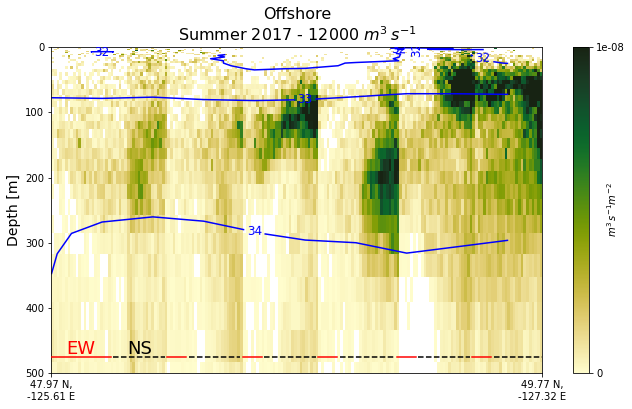

In [139]:
distlabel = False

fig, ax = plt.subplots(1,1,figsize = [11,6])

# def FluxOffshore(data, start, latS, latN, lonE, lonW, fjgrid, figrid, maxdepth, distlabel, ax, title):
x = FluxOffshore(Sdata, start, 199, 319, 594, 531, 555, 259, 500, distlabel, ax, 'Offshore\nSummer 2017')

#NS or EW
plt.plot(x[np.sum(steps[:0]):np.sum(steps[:1])],np.full(len(x[np.sum(steps[:0]):np.sum(steps[:1])]),475),'r',zorder=3)
plt.plot(x[np.sum(steps[:1]):np.sum(steps[:2])],np.full(len(x[np.sum(steps[:1]):np.sum(steps[:2])]),475),'k--',zorder=3)
plt.plot(x[np.sum(steps[:2]):np.sum(steps[:3])],np.full(len(x[np.sum(steps[:2]):np.sum(steps[:3])]),475),'r',zorder=3)
plt.plot(x[np.sum(steps[:3]):np.sum(steps[:4])],np.full(len(x[np.sum(steps[:3]):np.sum(steps[:4])]),475),'k--',zorder=3)
plt.plot(x[np.sum(steps[:4]):np.sum(steps[:5])],np.full(len(x[np.sum(steps[:4]):np.sum(steps[:5])]),475),'r',zorder=3)
plt.plot(x[np.sum(steps[:5]):np.sum(steps[:6])],np.full(len(x[np.sum(steps[:5]):np.sum(steps[:6])]),475),'k--',zorder=3)
plt.plot(x[np.sum(steps[:6]):np.sum(steps[:7])],np.full(len(x[np.sum(steps[:6]):np.sum(steps[:7])]),475),'r',zorder=3)
plt.plot(x[np.sum(steps[:7]):np.sum(steps[:8])],np.full(len(x[np.sum(steps[:7]):np.sum(steps[:8])]),475),'k--',zorder=3)
plt.plot(x[np.sum(steps[:8]):np.sum(steps[:9])],np.full(len(x[np.sum(steps[:8]):np.sum(steps[:9])]),475),'r',zorder=3)
plt.plot(x[np.sum(steps[:9]):np.sum(steps[:10])],np.full(len(x[np.sum(steps[:9]):np.sum(steps[:10])]),475),'k--',zorder=3)
plt.plot(x[np.sum(steps[:10]):np.sum(steps[:11])],np.full(len(x[np.sum(steps[:10]):np.sum(steps[:11])]),475),'r',zorder=3)
plt.plot(x[np.sum(steps[:11]):np.sum(steps)],np.full(len(x[np.sum(steps[:11]):np.sum(steps)]),475),'k--',zorder=3)

ax.text(0.155, 0.06, 'NS', transform=ax.transAxes, fontsize=18, color='k')
ax.text(0.03, 0.06, 'EW', transform=ax.transAxes, fontsize=18, color='r')


plt.savefig("./figures/OffshoreFlux.pdf")

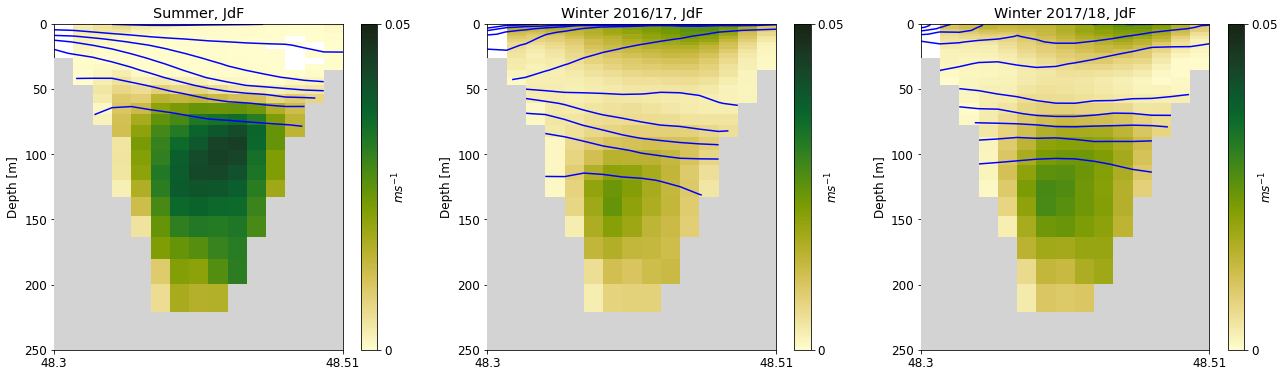

In [48]:
fig, ax = plt.subplots(1,3, figsize=[22,6])
JRFluxNS(Sdata, salfileS17, 'trans', init[1], init[2], init[3], init[4], ax[0], 'Summer, JdF')
JRFluxNS(Wdata16, salfileW16, 'trans', init[1], init[2], init[3], init[4], ax[1], 'Winter 2016/17, JdF')
JRFluxNS(Wdata17, salfileW17, 'trans', init[1], init[2], init[3], init[4], ax[2], 'Winter 2017/18, JdF')

# WM Flow

## Where do these different groups enter JdF??

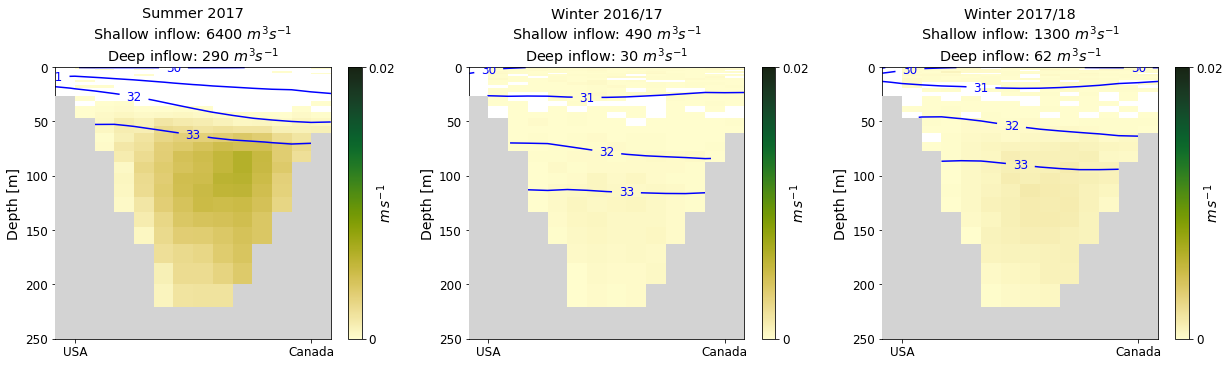

In [45]:
# deep salty salty
plt.rcParams['font.size'] = 12
salt = 32

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section != 0) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.final_section != 0) & (mydata.final_depth <= -200)]/time
title = "Summer 2017\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)


# winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section != 0) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.final_section != 0) & (mydata.final_depth <= -200)]/time
title = "Winter 2016/17\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW16)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section != 0) & (mydata.final_depth <= -200)]
depth = depthf(mydata.init_z[(mydata.final_section != 0) & (mydata.final_depth <= -200)]-1.)[0]
trans = mydata.init_transp[(mydata.final_section != 0) & (mydata.final_depth <= -200)]/time
title = "Winter 2017/18\nShallow inflow: " + str(round_to_2(np.sum(trans[depth<200]).values))[:-2] + " $m^3 s^{-1}$"+ "\nDeep inflow: "+ str(round_to_2(np.sum(trans[depth>=200]).values))[:-2] + " $m^3 s^{-1}$"
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileW17)

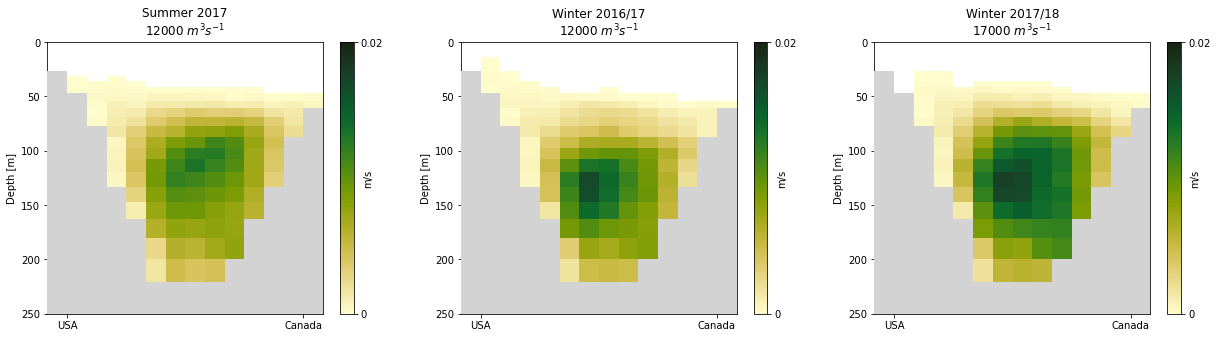

In [71]:
# shallow salty salty

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

# lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
# depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
# trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_section != 0) & (mydata.init_salt > 32.4) & (mydata.final_depth > -200)]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02)

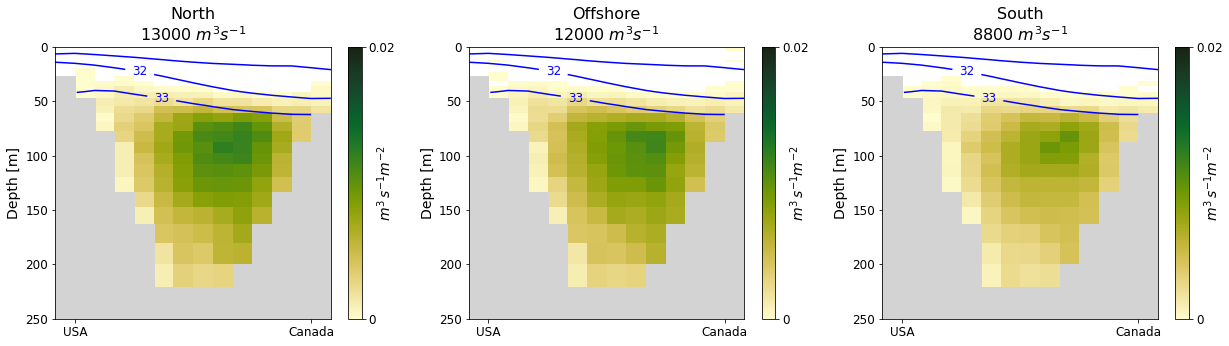

In [62]:
# do the shallow salty salty from different directions in the summer of 2017 enter the JdF differently????
# shallow salty salty
offcut = 595

plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1] - (start-3601)

lats = mydata.init_lat[(mydata.final_section == North[0])&(mydata.init_t >= start)]
depth = depthf(mydata.init_z[(mydata.final_section == North[0])&(mydata.init_t >= start)]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == North[0])&(mydata.init_t >= start)]/time
title = "North\n"  + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$"  
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)

lats = mydata.init_lat[np.logical_or((mydata.final_section==Offshore[0]),(mydata.final_section==Sslope[0])) & (mydata.final_x <= offcut) &(mydata.init_t >= start)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section==Offshore[0]),(mydata.final_section==Sslope[0])) & (mydata.final_x <= offcut) &(mydata.init_t >= start)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section==Offshore[0]),(mydata.final_section==Sslope[0])) & (mydata.final_x <= offcut) &(mydata.init_t >= start)]/time
title = "Offshore\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileS17)

# lats = mydata.init_lat[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))&(mydata.init_t >= start)]
# depth = depthf(mydata.init_z[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))&(mydata.init_t >= start)]-1.)[0]
# trans = mydata.init_transp[(mydata.init_salt > 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))&(mydata.init_t >= start)]/time
lats = mydata.init_lat[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_x > offcut) &(mydata.init_t >= start)]
depth = depthf(mydata.init_z[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_x > offcut) &(mydata.init_t >= start)]-1.)[0]
trans = mydata.init_transp[np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0])) & (mydata.final_x > offcut) &(mydata.init_t >= start)]/time
title = "South\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileS17)

plt.savefig("./figures/SummerUpwelledInflow.pdf")

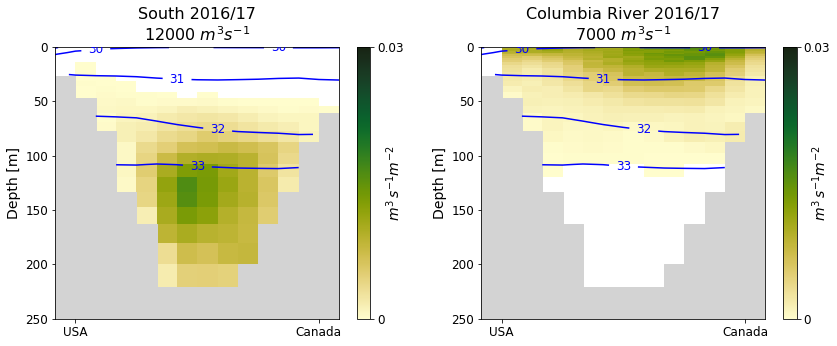

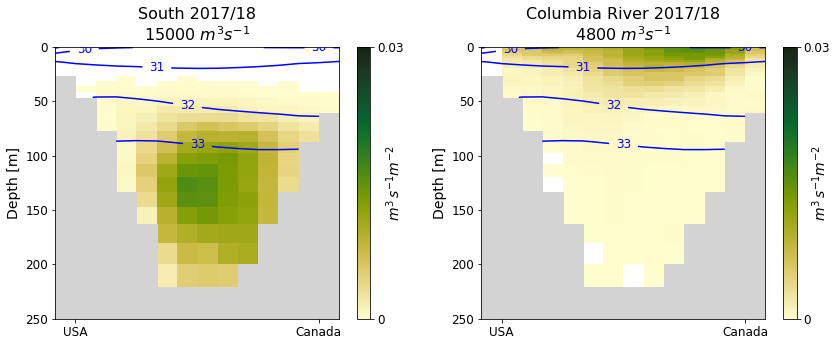

In [71]:
# one plot of fresh and south entering JdF in the winter
# 2016/17
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(1,2,figsize=(14,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt >= 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt >= 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt >= 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "South\n" + str(np.round(np.sum(trans),0).values)
title = "South 2016/17\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.03, salfileW16)

lats = mydata.init_lat[(mydata.init_salt < 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt < 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt < 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "Columbia River\n" + str(np.round(np.sum(trans),0).values)
title = "Columbia River 2016/17\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.03, salfileW16)
plt.savefig("./figures/W16MajorInflow.pdf")

# 2017/18
fig, ax = plt.subplots(1,2,figsize=(14,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt >= 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt >= 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt >= 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "South\n" + str(np.round(np.sum(trans),0).values)
title = "South 2017/18\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.03, salfileW17)

lats = mydata.init_lat[(mydata.init_salt < 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt < 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt < 32) & (mydata.final_depth > Wsdep) & (mydata.final_x > offcut) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
# title = "Columbia River\n" + str(np.round(np.sum(trans),0).values)
title = "Columbia River 2017/18\n"+ str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title, fontsize=16)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.03, salfileW17)
plt.savefig("./figures/W17MajorInflow.pdf")


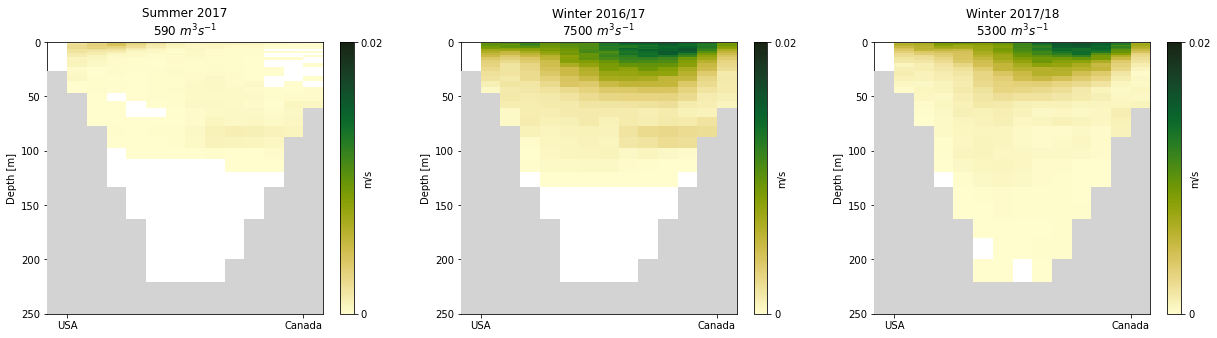

In [76]:
# fresh

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200)& np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.init_z[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.init_transp[(mydata.init_salt <= 32.4) & (mydata.final_depth > -200) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02)

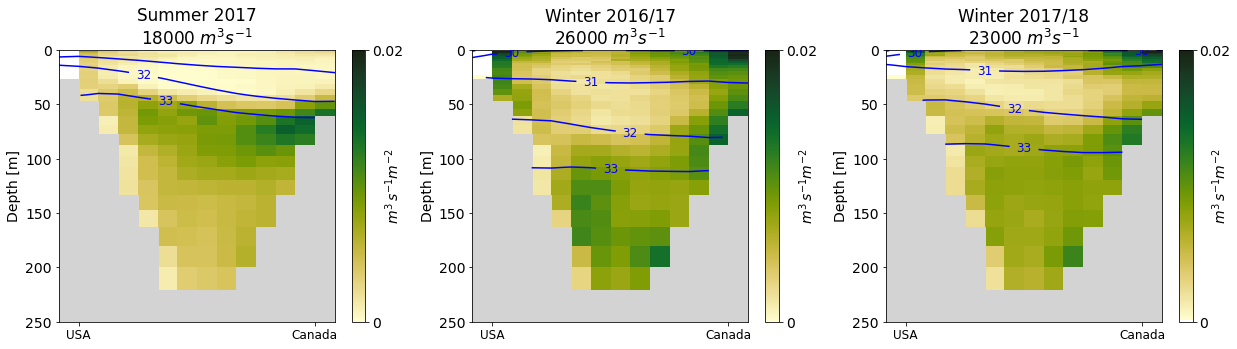

In [25]:
# where does the strait outflow enter the PRT
tide=24
plt.rcParams['font.size'] = 14

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.init_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.init_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW16)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.init_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.init_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.init_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileW17)

plt.savefig("./figures/StraitInflow.pdf")

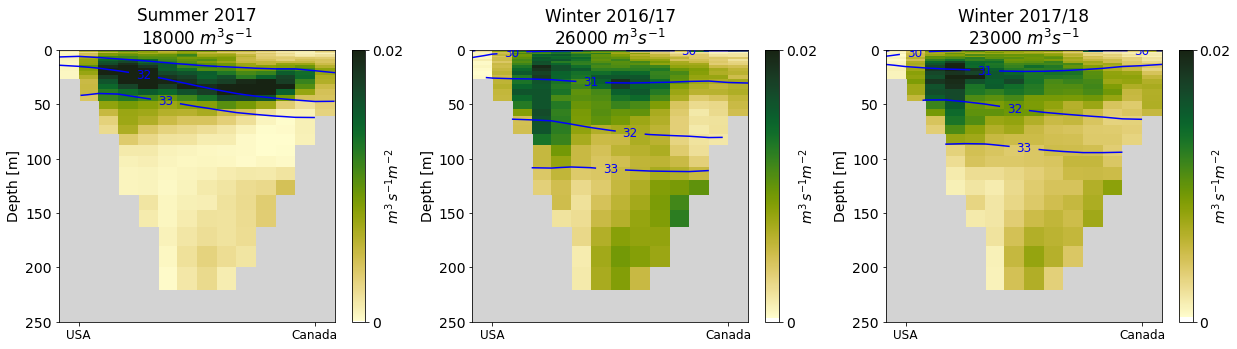

In [26]:
# where does the strait outflow leave the PRT..?
tide=24
plt.rcParams['font.size'] = 14

#summer 2017
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = "Summer 2017\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[0].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[0], lats, trans, depth, 0.02, salfileS17)


#winter 2016/17

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = "Winter 2016/17\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[1].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[1], lats, trans, depth, 0.02, salfileW16)

#winter 2017/18

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lats = mydata.final_lat[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]
depth = depthf(mydata.final_z[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]-1.)[0]
trans = mydata.final_transp[(mydata.final_section == 0) & (mydata.init_t-mydata.final_t > tide)]/time
title = "Winter 2017/18\n" + str(round_to_2(np.sum(trans).values))[:-2]+ " $m^3 s^{-1}$" 
ax[2].set_title(title)
FluxSpecificNS(init[1], init[2], init[3], init[4], ax[2], lats, trans, depth, 0.02, salfileW17)

plt.savefig("./figures/StraitOutflow.pdf")

# can we seperate the water masses on the southern boarder

In [9]:
def FluxSpecificEW(lonW, lonE, figrid, maxdepth, ax, lons, trans, depth, high, salfile):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum())).values
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
#     t_max = (high/np.sum(trans)).values
    t_max = (high/np.sum(trans))

    dist = lons/m2lon
        
    H1, _, _ = np.histogram2d(dist, depth, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    tick = np.round(((t_max*np.sum(trans))),2)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label('m/s', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(t_dist[lonW-1:lonE+1]), np.array(t_depths))
    salinity = 0.5*(np.ma.array(salfile.so[:, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.so[:, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([t_dist[lonW], t_dist[lonE-1]])
    ax.set_xticklabels(np.round([t_lons[lonW], t_lons[lonE-1]],2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()

### winter 2016/17

In [10]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lon = mydata.final_lon[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.final_z[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.final_transp[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
salt = mydata.final_salt[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
temp = mydata.final_temp[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]


In [11]:
data = {'lon':lon,'depth':depth,'trans':trans,'salt':salt,'temp':temp}
d = pd.DataFrame(data)

In [12]:
m = -4
b = 144

Text(0.5, 1.0, 'Minty')

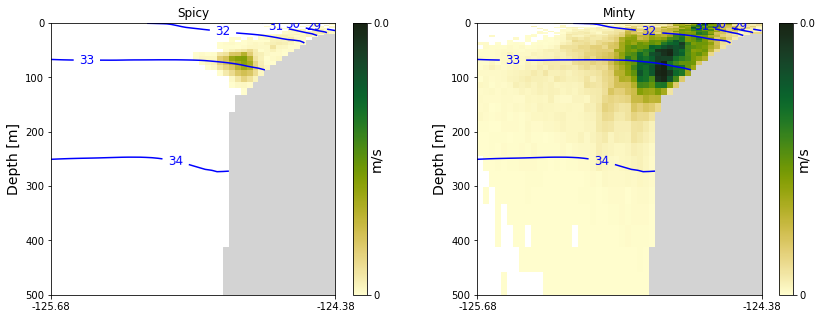

In [14]:
Sslope[1] = 595

fig, ax = plt.subplots(1,2,figsize=(14,5))
high = 0.005

FluxSpecificEW(Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[0], np.array(d.lon[(d.temp >= m*d.salt + b)]), 
               np.array(d.trans[(d.temp >= m*d.salt + b)]), np.array(d.depth[(d.temp >= m*d.salt + b)]), high, salfileW16)

# FluxSpecificEW(Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[1], np.array(d.lon[(d.temp >= m*d.salt + b) & (d.temp < m2*d.salt + b2)]), 
#                np.array(d.trans[(d.temp >= m*d.salt + b) & (d.temp < m2*d.salt + b2)]), np.array(d.depth[(d.temp >= m*d.salt + b) & (d.temp < m2*d.salt + b2)]), high, salfileW16)

FluxSpecificEW(Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[1], np.array(d.lon[d.temp < m*d.salt + b]), 
               np.array(d.trans[d.temp < m*d.salt + b]), np.array(d.depth[d.temp < m*d.salt + b]), high, salfileW16)

ax[0].set_title('Spicy')
ax[1].set_title('Minty')

### winter 2017/18

In [17]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lon = mydata.final_lon[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.final_z[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.final_transp[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
salt = mydata.final_salt[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
temp = mydata.final_temp[(mydata.final_salt >= 32) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]


In [18]:
data = {'lon':lon,'depth':depth,'trans':trans,'salt':salt,'temp':temp}
d = pd.DataFrame(data)

In [19]:
m = -4
b = 144

Text(0.5, 1.0, 'Lower')

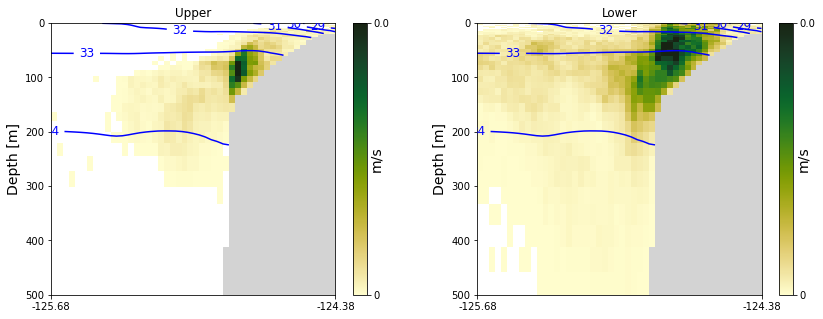

In [21]:
Sslope[1] = 595

fig, ax = plt.subplots(1,2,figsize=(14,5))
high = 0.005

FluxSpecificEW(Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[0], np.array(d.lon[d.temp >= m*d.salt + b]), 
               np.array(d.trans[d.temp >= m*d.salt + b]), np.array(d.depth[d.temp >= m*d.salt + b]), high, salfileW17)

FluxSpecificEW(Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[1], np.array(d.lon[d.temp < m*d.salt + b]), 
               np.array(d.trans[d.temp < m*d.salt + b]), np.array(d.depth[d.temp < m*d.salt + b]), high, salfileW17)

ax[0].set_title('Upper')
ax[1].set_title('Lower')

### Summer 2017

In [23]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lon = mydata.final_lon[(mydata.final_salt >= 32) & (mydata.init_t >= start) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
depth = depthf(mydata.final_z[(mydata.final_salt >= 32) & (mydata.init_t >= start) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]-1.)[0]
trans = mydata.final_transp[(mydata.final_salt >= 32) & (mydata.init_t >= start) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]/time
salt = mydata.final_salt[(mydata.final_salt >= 32) & (mydata.init_t >= start) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]
temp = mydata.final_temp[(mydata.final_salt >= 32) & (mydata.init_t >= start) & (mydata.final_x > 595) & np.logical_or((mydata.final_section == Sshelf[0]),(mydata.final_section == Sslope[0]))]

In [24]:
data = {'lon':lon,'depth':depth,'trans':trans,'salt':salt,'temp':temp}
d = pd.DataFrame(data)

In [25]:
m = -2.8
b = 102.41600000000003

Text(0.5, 1.0, 'Lower')

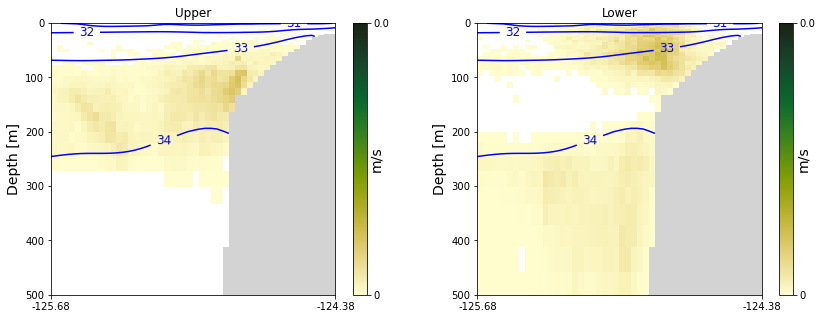

In [26]:
Sslope[1] = 595

fig, ax = plt.subplots(1,2,figsize=(14,5))
high = 0.005

FluxSpecificEW(Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[0], np.array(d.lon[d.temp >= m*d.salt + b]), 
               np.array(d.trans[d.temp >= m*d.salt + b]), np.array(d.depth[d.temp >= m*d.salt + b]), high, salfileS17)

FluxSpecificEW(Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[1], np.array(d.lon[d.temp < m*d.salt + b]), 
               np.array(d.trans[d.temp < m*d.salt + b]), np.array(d.depth[d.temp < m*d.salt + b]), high, salfileS17)

ax[0].set_title('Upper')
ax[1].set_title('Lower')